In [1]:
import numpy as np
import os
import pandas
import datetime
import matplotlib.pyplot as plt
import world_bank_data as wb
import seaborn as sns; sns.set_theme()
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [3]:
def plot_kmeans_clusters(x_column, y_column, df, clusters_data):
    colors = cm.nipy_spectral(clusters_data.labels_.astype(float) / len(clusters_data.cluster_centers_))

    x = df[x_column]
    y = df[y_column]

    plt.scatter(x, y, marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusters_data.cluster_centers_
    # Draw white circles at cluster centers
    plt.scatter(centers[:, df.columns.get_loc(x_column)],
                centers[:, df.columns.get_loc(y_column)],
                marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        plt.scatter(c[df.columns.get_loc(x_column)],
                    c[df.columns.get_loc(y_column)],
                    marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    
    plt.show()

# Prepare data

In [4]:
df1 = pandas.read_csv("crunched_data_filled.csv")
df1

,Unnamed: 0,casesPer1000,deathsPer1000,NovemberCasesPercent,NovemberDeathsPercent,casesSinceSeptember,deathsSinceSeptember,popData2019,casesSinceNovember,deathsSinceNovember,NY.GDP.PCAP.CD,EN.POP.DNST,SH.MED.BEDS.ZS,SH.MED.PHYS.ZS,SP.POP.65UP.TO.ZS,SH.STA.TRAF.P5,EN.ATM.PM25.MC.M3,countriesAndTerritories,countryterritoryCode,continentExp
0,0,0.133485,0.005652,0.357424,0.376744,5078.0,215.0,38041757.0,1815.0,81.0,502.115487,56.937760,0.5,0.27820,2.615794,15.10,56.910808,Afghanistan,AFG,Asia
1,1,6.237015,0.115985,0.369630,0.331325,17853.0,332.0,2862427.0,6599.0,110.0,5352.857411,104.612263,2.9,1.21640,14.202631,13.60,18.200603,Albania,ALB,Europe
2,2,0.526629,0.014819,0.404358,0.286834,22673.0,638.0,43053054.0,9168.0,183.0,3948.343279,17.730075,1.9,1.71930,6.552778,23.80,38.884011,Algeria,DZA,Africa
3,3,60.398808,0.288801,0.230385,0.611111,4601.0,22.0,76177.0,1060.0,0.0,40886.391165,163.842553,2.5,3.33330,14.465041,7.60,10.307621,Andorra,AND,Europe
4,4,0.333194,0.006599,0.279046,0.200000,10604.0,210.0,31825299.0,2959.0,42.0,2973.591160,24.713052,0.8,0.21460,2.199342,23.60,32.388505,Angola,AGO,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,208,0.008644,0.011059,1.000000,1.000000,1.0,0.0,36831.5,0.0,0.0,3161.530935,177.556225,2.1,0.39795,3.392263,11.15,17.675435,Wallis_and_Futuna,NaN,Oceania
209,209,6.477679,0.096792,0.120453,0.088367,0.0,0.0,582458.0,0.0,0.0,5229.344178,69.311013,2.6,0.99575,5.856752,19.75,29.779355,Western_Sahara,ESH,Africa
210,210,0.004081,0.001337,0.075630,0.076923,119.0,39.0,29161922.0,9.0,3.0,968.159048,53.977853,0.7,0.52510,2.902141,21.50,50.456007,Yemen,YEM,Asia
211,211,0.283970,0.003527,0.134464,0.015873,5072.0,63.0,17861034.0,682.0,1.0,1291.343357,23.341479,2.0,1.18670,2.115315,24.70,27.438035,Zambia,ZMB,Africa


In [5]:
df_new = df1.copy()
df_new = df_new.drop(columns=[
    "Unnamed: 0",
    "countriesAndTerritories",
    "countryterritoryCode",
    "continentExp",
    "popData2019",
    "casesSinceNovember",
    "deathsSinceNovember",
    "casesSinceSeptember",
    "deathsSinceSeptember",
])
df_new

,casesPer1000,deathsPer1000,NovemberCasesPercent,NovemberDeathsPercent,NY.GDP.PCAP.CD,EN.POP.DNST,SH.MED.BEDS.ZS,SH.MED.PHYS.ZS,SP.POP.65UP.TO.ZS,SH.STA.TRAF.P5,EN.ATM.PM25.MC.M3
0,0.133485,0.005652,0.357424,0.376744,502.115487,56.937760,0.5,0.27820,2.615794,15.10,56.910808
1,6.237015,0.115985,0.369630,0.331325,5352.857411,104.612263,2.9,1.21640,14.202631,13.60,18.200603
2,0.526629,0.014819,0.404358,0.286834,3948.343279,17.730075,1.9,1.71930,6.552778,23.80,38.884011
3,60.398808,0.288801,0.230385,0.611111,40886.391165,163.842553,2.5,3.33330,14.465041,7.60,10.307621
4,0.333194,0.006599,0.279046,0.200000,2973.591160,24.713052,0.8,0.21460,2.199342,23.60,32.388505
...,...,...,...,...,...,...,...,...,...,...,...
208,0.008644,0.011059,1.000000,1.000000,3161.530935,177.556225,2.1,0.39795,3.392263,11.15,17.675435
209,6.477679,0.096792,0.120453,0.088367,5229.344178,69.311013,2.6,0.99575,5.856752,19.75,29.779355
210,0.004081,0.001337,0.075630,0.076923,968.159048,53.977853,0.7,0.52510,2.902141,21.50,50.456007
211,0.283970,0.003527,0.134464,0.015873,1291.343357,23.341479,2.0,1.18670,2.115315,24.70,27.438035


In [6]:
df_new_sick = df1.copy()
df_new_sick = df_new_sick.drop(columns=[
    "Unnamed: 0",
    "countriesAndTerritories",
    "countryterritoryCode",
    "continentExp",
    "popData2019",
    "casesSinceNovember",
    "deathsSinceNovember",
    "casesSinceSeptember",
    "deathsSinceSeptember",
    "NY.GDP.PCAP.CD",
    "EN.POP.DNST",
    "SH.MED.BEDS.ZS",
    "SH.MED.PHYS.ZS",
    "SP.POP.65UP.TO.ZS",
    "SH.STA.TRAF.P5",
    "EN.ATM.PM25.MC.M3",
])
df_new_sick

,casesPer1000,deathsPer1000,NovemberCasesPercent,NovemberDeathsPercent
0,0.133485,0.005652,0.357424,0.376744
1,6.237015,0.115985,0.369630,0.331325
2,0.526629,0.014819,0.404358,0.286834
3,60.398808,0.288801,0.230385,0.611111
4,0.333194,0.006599,0.279046,0.200000
...,...,...,...,...
208,0.008644,0.011059,1.000000,1.000000
209,6.477679,0.096792,0.120453,0.088367
210,0.004081,0.001337,0.075630,0.076923
211,0.283970,0.003527,0.134464,0.015873


# Statistics

In [7]:
df_ready_data_numeric_sum = pandas.DataFrame(df1.isnull().sum(), columns = ["missing"])
df_ready_data_numeric_max = pandas.DataFrame(df1.max(), columns = ["max"])
df_ready_data_numeric_min = pandas.DataFrame(df1.min(), columns = ["min"])
df_ready_data_numeric_mean = pandas.DataFrame(df1.mean(), columns = ["mean"])
df_ready_data_numeric_median = pandas.DataFrame(df1.median(), columns = ["median"])
df_ready_data_numeric_std = pandas.DataFrame(df1.std(), columns = ["std"])

frames = [df_ready_data_numeric_sum,
         df_ready_data_numeric_max,
         df_ready_data_numeric_min,
         df_ready_data_numeric_mean,
         df_ready_data_numeric_median,
         df_ready_data_numeric_std]

df_statistics = pandas.concat(frames, axis=1)
df_statistics

,missing,max,min,mean,median,std
Unnamed: 0,0,212,0,1.060000e+02,1.060000e+02,6.163197e+01
casesPer1000,0,60.3988,0.000278961,6.314877e+00,2.119701e+00,9.140313e+00
deathsPer1000,0,0.60084,1.18567e-05,9.592717e-02,6.711609e-02,1.103994e-01
NovemberCasesPercent,0,1,0.0142857,2.954181e-01,2.580961e-01,1.758184e-01
NovemberDeathsPercent,0,1,0.015873,3.846011e-01,3.235294e-01,2.531340e-01
casesSinceSeptember,0,5.19333e+06,0,1.351580e+05,5.078000e+03,5.372691e+05
deathsSinceSeptember,0,65166,0,2.192033e+03,6.300000e+01,7.810843e+03
popData2019,0,1.43378e+09,815,3.601071e+07,6.777453e+06,1.405660e+08
casesSinceNovember,0,1.85746e+06,0,3.935928e+04,1.284000e+03,1.539674e+05
deathsSinceNovember,0,15892,0,5.806808e+02,1.300000e+01,1.754988e+03


# Clustering - all data

## automatic n clusters

In [8]:
clustering = AgglomerativeClustering().fit(df_new)
clustering.labels_

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

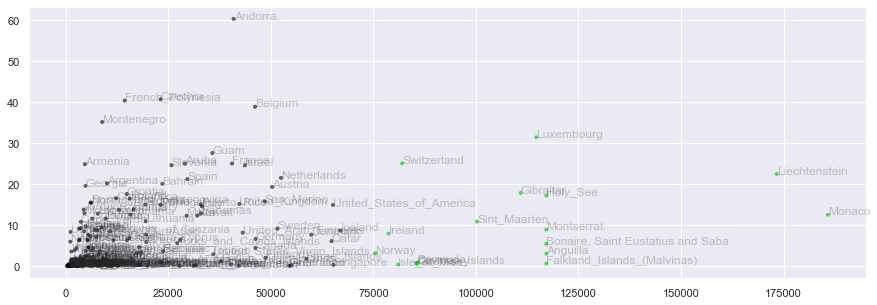

In [9]:
#%matplotlib notebook
colors = cm.nipy_spectral(clustering.labels_.astype(float) / clustering.n_clusters_)
plt.scatter(df_new["NY.GDP.PCAP.CD"], df_new["casesPer1000"], alpha=0.5, marker='.', c=colors)
for i, txt in enumerate(df1.countriesAndTerritories):
    plt.annotate(txt, (df_new["NY.GDP.PCAP.CD"][i], df_new["casesPer1000"][i]), alpha=0.25)

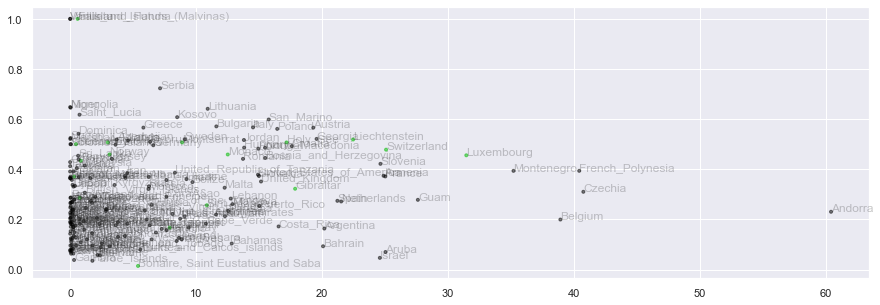

In [10]:
#%matplotlib notebook
colors = cm.nipy_spectral(clustering.labels_.astype(float) / clustering.n_clusters_)
plt.scatter(df_new["casesPer1000"], df_new["NovemberCasesPercent"], alpha=0.5, marker='.', c=colors)
for i, txt in enumerate(df1.countriesAndTerritories):
    plt.annotate(txt, (df_new["casesPer1000"][i], df_new["NovemberCasesPercent"][i]), alpha=0.25)

## 3 clusters

In [11]:
clustering = AgglomerativeClustering(n_clusters=3).fit(df_new)
clustering.labels_

array([2, 2, 2, 1, 2, 0, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0,
       2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0,
       1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 0,
       2, 2, 1, 2, 2, 2, 2, 0, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0,
       2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 1, 2,
       2, 2, 1, 2, 1, 2, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

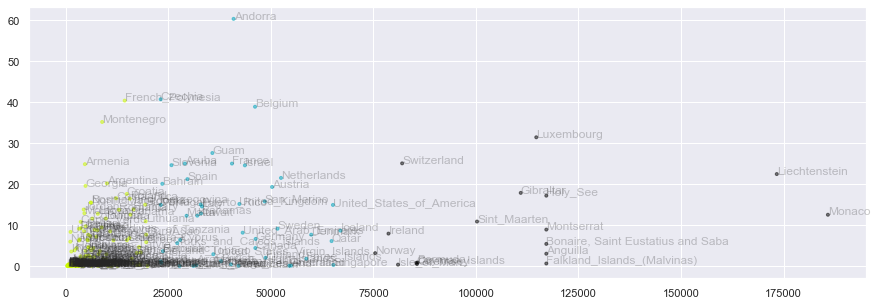

In [12]:
#%matplotlib notebook
colors = cm.nipy_spectral(clustering.labels_.astype(float) / clustering.n_clusters_)
plt.scatter(df_new["NY.GDP.PCAP.CD"], df_new["casesPer1000"], alpha=0.5, marker='.', c=colors)
for i, txt in enumerate(df1.countriesAndTerritories):
    plt.annotate(txt, (df_new["NY.GDP.PCAP.CD"][i], df_new["casesPer1000"][i]), alpha=0.25)

## dendrogram

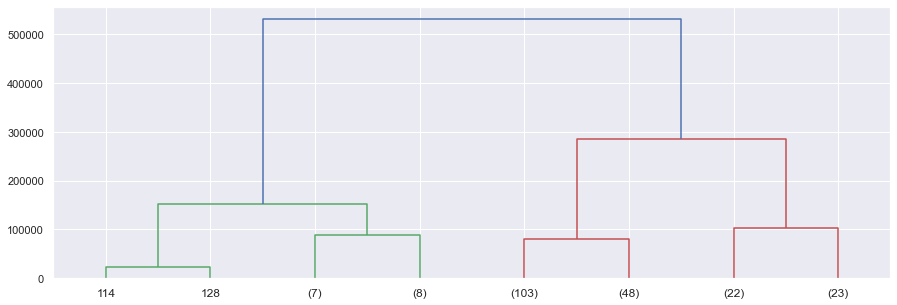

In [13]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(df_new)
plot_dendrogram(clustering, truncate_mode='level', p=2)

# Clustering - only covid data

## automatic n clusters

In [14]:
clustering_sick = AgglomerativeClustering().fit(df_new_sick)
clustering_sick.labels_

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

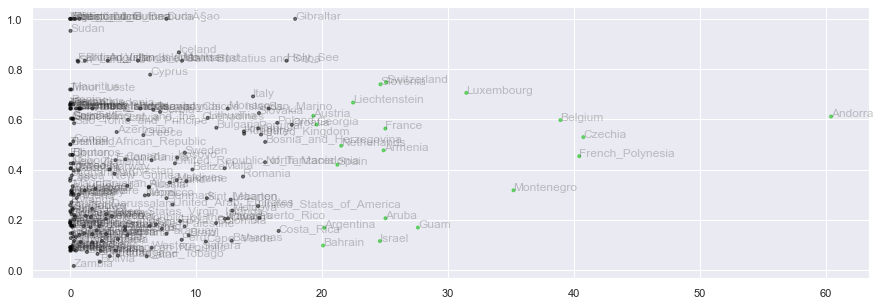

In [15]:
#%matplotlib notebook
colors = cm.nipy_spectral(clustering_sick.labels_.astype(float) / clustering_sick.n_clusters_)
plt.scatter(df_new_sick["casesPer1000"], df_new_sick["NovemberDeathsPercent"], alpha=0.5, c=colors, marker='.')
for i, txt in enumerate(df1.countriesAndTerritories):
    plt.annotate(txt, (df_new_sick["casesPer1000"][i], df_new_sick["NovemberDeathsPercent"][i]), alpha=0.25)

### 3 clusters

In [16]:
clustering_sick = AgglomerativeClustering(n_clusters=3).fit(df_new_sick)
clustering_sick.labels_

array([2, 1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 0, 2, 2, 2, 0, 1, 2, 2,
       2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2,
       2, 1, 2, 1, 2, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 0, 1, 2, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1,
       2, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2,
       1, 2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 0, 1,
       1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2], dtype=int64)

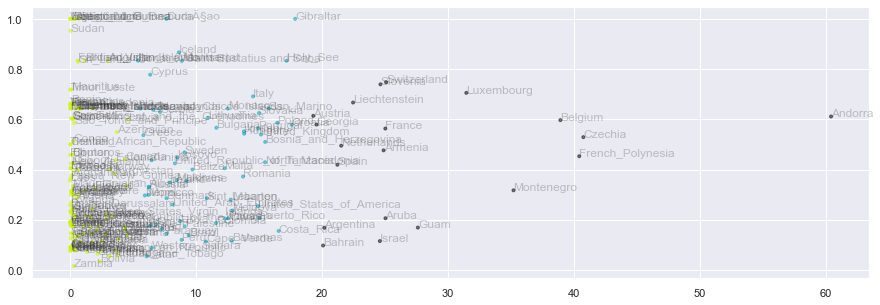

In [17]:
#%matplotlib notebook
colors = cm.nipy_spectral(clustering_sick.labels_.astype(float) / clustering_sick.n_clusters_)
plt.scatter(df_new_sick["casesPer1000"], df_new_sick["NovemberDeathsPercent"], alpha=0.5, c=colors, marker='.')
for i, txt in enumerate(df1.countriesAndTerritories):
    plt.annotate(txt, (df_new_sick["casesPer1000"][i], df_new_sick["NovemberDeathsPercent"][i]), alpha=0.25)

## dendrogram

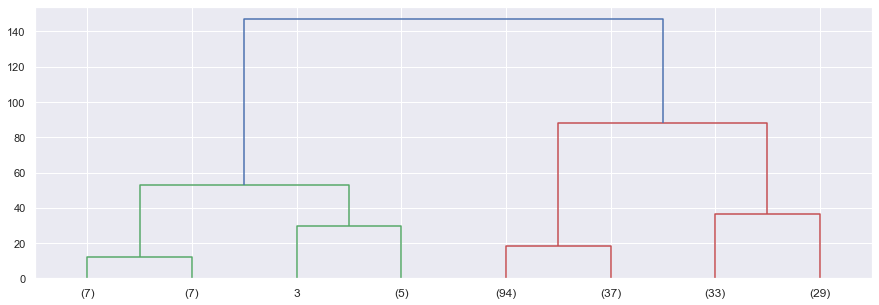

In [18]:
clustering_sick = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(df_new_sick)
plot_dendrogram(clustering_sick, truncate_mode='level', p=2)

# Kmeans

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=43)

kmeans_sick = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=43)

clusters_data = kmeans.fit(df_new)
clusters_data_sick = kmeans_sick.fit(df_new_sick)

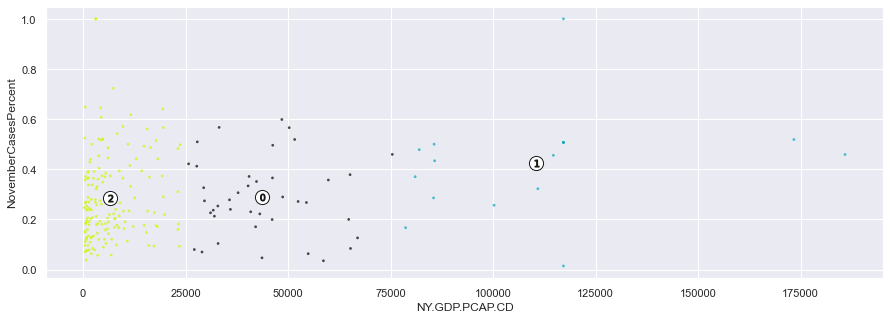

In [20]:
plot_kmeans_clusters("NY.GDP.PCAP.CD", "NovemberCasesPercent", df_new, clusters_data)

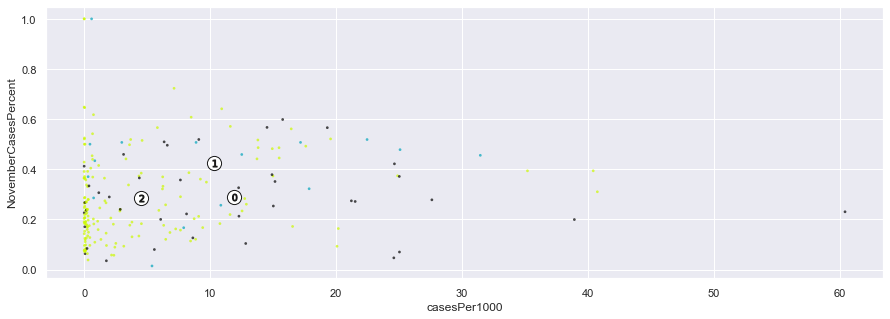

In [21]:
plot_kmeans_clusters("casesPer1000", "NovemberCasesPercent", df_new, clusters_data)

In [37]:
df_new_centers = pandas.DataFrame(clusters_data.cluster_centers_)
df_new_centers.columns = df_new.columns
df_new_centers

,casesPer1000,deathsPer1000,NovemberCasesPercent,NovemberDeathsPercent,NY.GDP.PCAP.CD,EN.POP.DNST,SH.MED.BEDS.ZS,SH.MED.PHYS.ZS,SP.POP.65UP.TO.ZS,SH.STA.TRAF.P5,EN.ATM.PM25.MC.M3
0,11.884489,0.123133,0.287976,0.435491,43699.942251,411.865576,4.703500,3.257640,15.099224,7.486250,16.591618
1,10.346216,0.089392,0.423917,0.718223,110582.143618,4709.077560,6.770401,4.656756,12.162991,2.475000,10.743881
2,4.485031,0.089662,0.284219,0.337636,6595.735921,153.063431,2.595159,1.523949,7.504486,19.175159,29.907522


### only covid data

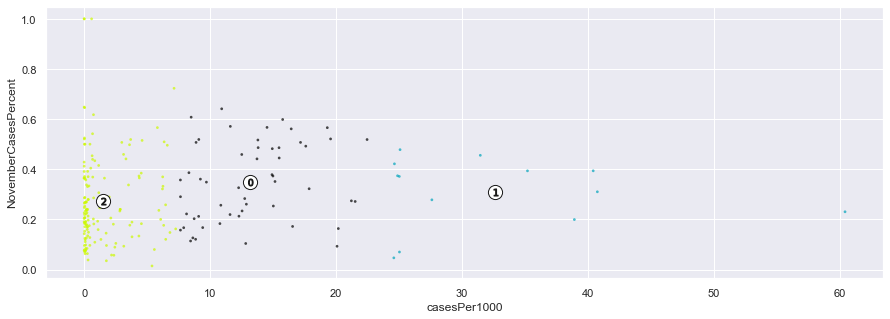

In [23]:
plot_kmeans_clusters("casesPer1000", "NovemberCasesPercent", df_new_sick, clusters_data_sick)

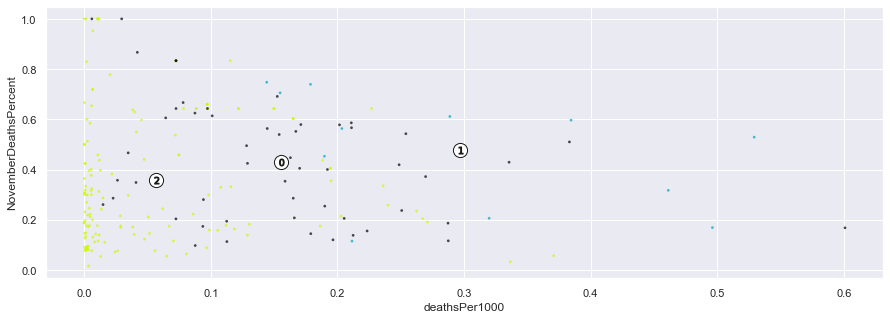

In [24]:
plot_kmeans_clusters("deathsPer1000", "NovemberDeathsPercent", df_new_sick, clusters_data_sick)

In [36]:
df_sick_centers = pandas.DataFrame(clusters_data_sick.cluster_centers_)
df_sick_centers.columns = df_new_sick.columns
df_sick_centers

,casesPer1000,deathsPer1000,NovemberCasesPercent,NovemberDeathsPercent
0,13.154634,0.155621,0.348245,0.429738
1,32.610085,0.297059,0.309438,0.479029
2,1.523416,0.056618,0.275132,0.359976
